# Transformer Model!
## Needs:


In [70]:
## imports 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import pandas as pd

In [71]:
## The building blocks of a transformer are:
# 1. Multi-head self-attention
# 2. Feedforward neural network
# 3. Positional Encoding
# 4. Layer normalization
# 5. Residual connections
# 6. Dropout

In [72]:
# ## Impoorting the data
# merged_dataset = pd.read_csv("/home/db24/irp-db24/results/processed_merged_dataset.csv")

In [73]:
# merged_dataset.columns

In [74]:
# merged_dataset_drop = merged_dataset.drop(columns=['Unnamed: 0','patient_id_INH001', 'patient_id_INH002', 'patient_id_INH003',
#        'patient_id_INH004', 'patient_id_INH005', 'patient_id_INH006',
#        'patient_id_INH007', 'patient_id_INH008', 'patient_id_INH010',
#        'patient_id_INH011', 'patient_id_INH012', 'patient_id_INH013',
#        'patient_id_INH014', 'patient_id_INH015', 'patient_id_INH017',
#        'patient_id_INH018', 'patient_id_INH020', 'patient_id_INH023',
#        'patient_id_INH024', 'patient_id_INH025', 'patient_id_INH027',
#        'patient_id_INH028', 'patient_id_INH100', 'patient_id_INH101',
#        'patient_id_INH102', 'patient_id_INH103', 'patient_id_INH106',
#        'patient_id_INH107', 'patient_id_INH108', 'patient_id_INH109',
#        'patient_id_INH110', 'patient_id_INH111', 'patient_id_INH112',
#        'patient_id_INH113', 'patient_id_INH114', 'patient_id_INH115',
#        'patient_id_INH117', 'patient_id_INH119', 'patient_id_INH120',
#        'patient_id_INH121', 'patient_id_INH123', 'patient_id_INH124',
#        'patient_id_INH127', 'patient_id_INH128', 'patient_id_INH129',
#        'patient_id_INH130', 'patient_id_INH131', 'patient_id_INH132',
#        'patient_id_INH135', 'patient_id_INH138', 'patient_id_INH139'])

In [75]:
# ## I could reuse some of the code form Big Data to create a variational autoencoder
# ## The decoder part though should be both an autoencoder and a transformer 

# merged_dataset_small = merged_dataset_drop.sample(frac=1, random_state=42)
# merged_dataset_small = (merged_dataset_small - merged_dataset_small.mean()) / merged_dataset_small.std()

# merged_dataset_small.columns

## SINE WAVE

In [76]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define time vector (e.g., from 0 to 10 seconds, with 1000 points)
time = np.linspace(0, 86400, 10000)

# Define sine wave parameters
frequency = 1.5  # Hz (change this to adjust the wave frequency)
amplitude = 2.3547  # unitless (change this to adjust the wave amplitude)

# Generate sine wave values
sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)

# Create DataFrame
sine_df_raw = pd.DataFrame({
    'Time (seconds)': time,
    'Sine Amplitude': sine_wave
})

# Total seconds in a day and week
SECONDS_PER_HOUR = 3600
SECONDS_PER_DAY = 86400
SECONDS_PER_WEEK = SECONDS_PER_DAY * 7

# Compute cyclical features
sine_df_raw['dow_cos'] = np.cos(2 * np.pi * (sine_df_raw['Time (seconds)'] % SECONDS_PER_WEEK) / SECONDS_PER_WEEK)
sine_df_raw['dow_sin'] = np.sin(2 * np.pi * (sine_df_raw['Time (seconds)'] % SECONDS_PER_WEEK) / SECONDS_PER_WEEK)
sine_df_raw['hour_cos'] = np.cos(2 * np.pi * (sine_df_raw['Time (seconds)'] % SECONDS_PER_DAY) / SECONDS_PER_DAY)


sine_df = (sine_df_raw - sine_df_raw.mean()) / sine_df_raw.std()
sine_df

,Time (seconds),Sine Amplitude,dow_cos,dow_sin,hour_cos
0,-1.731791,-3.679768e-14,1.137591,-1.830207,1.413931
1,-1.731445,-3.405338e-01,1.137591,-1.829816,1.413930
2,-1.731098,-6.610281e-01,1.137590,-1.829424,1.413930
3,-1.730752,-9.426226e-01,1.137590,-1.829032,1.413928
4,-1.730405,-1.168746e+00,1.137590,-1.828641,1.413926
...,...,...,...,...,...
9995,1.730405,1.168746e+00,-2.180728,1.580128,1.413926
9996,1.730752,9.426226e-01,-2.181347,1.580372,1.413928
9997,1.731098,6.610281e-01,-2.181966,1.580616,1.413930
9998,1.731445,3.405338e-01,-2.182585,1.580861,1.413930


## TRANSFORMER VARIATIONAL AUTOENCODER

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# === Positional Encoding for continuous features ===
## The transformer architecture requires positional encoding to capture the order of the sequence.
## Because I am feeding a long vecotr without encoding - the transformer would not know the order of the features.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=1000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1) ## this is a range so you are creating the position of the features from 0 to max_range
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        # sin and cos are there so that the model can learn the relative position of the features
        # because they stay between -1 and 1 it means it's not too distant form each other 
        # so step 1 and step 124153787987 are not too distant from each other after sin and cos transformation
        # div_term is to tell you at which step you are in the sequence
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))


    def forward(self, x):
        """
        x: [batch_size, seq_len, d_model]
        """
        # x is expected to be of shape [batch_size, seq_len, d_model]
        seq_len = x.size(1)
        
        # this is ensuring we are adding the above positional encoding to my vector
        x = x + self.pe[:, :seq_len, :]
        
        return x

# === Transformer Encoder-Decoder VAE ===
class TransformerVAE(nn.Module):
    def __init__(self, feature_dim=43, d_model=128, latent_dim=16, num_heads=4, num_layers=2, dropout=0.1, seq_len=30, forecast_steps=5):
        super(TransformerVAE, self).__init__()

        # Project input features to model dimension
        self.input_proj = nn.Linear(feature_dim, d_model) # this is turning my 43 features into 64 higher dimension
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length=seq_len + forecast_steps) # --> this is adding positional encoding to each step

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=128, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Latent space VAE parameters
        # in here I am just setting two neural networks to learn the mean and log variance of the latent space
        # I will use them later
        self.fc_mu = nn.Linear(d_model, latent_dim)
        self.fc_logvar = nn.Linear(d_model, latent_dim)

        # Decoder
        self.latent_to_hidden = nn.Linear(latent_dim, d_model)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=128, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, feature_dim) 
        ## a final translation layer to get back to the original feature dimension
        ## this is the reconstruction part of the VAE

        self.forecast_proj = nn.Linear(d_model, feature_dim)  # Predict next timestep features
        ## this is the forecasting part of the VAE

    def generate_causal_mask(self, size, device):
        mask = torch.triu(torch.ones(size, size, device=device), diagonal=1).bool()
        return mask

    def encode(self, x):
        """
        x: [batch_size, seq_len, feature_dim]
        """
        x = self.input_proj(x)  # [batch_size, seq_len, d_model]
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)  # Changes shape from [batch_size, seq_len, d_model] → [seq_len, batch_size, d_model].
        # Required by PyTorch's nn.TransformerEncoder, which expects sequence-first format.
        # This is creating a probabilistic latent space
        encoded = self.transformer_encoder(x)  # [seq_len, batch_size, d_model]
        pooled = encoded.mean(dim=0)  # [batch_size, d_model]

        mu = self.fc_mu(pooled)
        logvar = self.fc_logvar(pooled)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, seq_len, tgt_input=None, pred_steps=1, teacher_force_prob=1.0):
        """
        Decode from latent space, reconstruct input sequence, and forecast future steps.
        
        Args:
            z: [batch_size, latent_dim] - latent vector
            seq_len: int - length of the input sequence
            tgt_input: [seq_len, batch_size, d_model] or None - optionally, teacher-forced inputs
            pred_steps: int - number of future steps to predict
            teacher_force_prob: float - probability of using teacher-forcing during recursive forecast
        """
        
        # Expand latent vector to memory for the decoder
        memory = self.latent_to_hidden(z)  # [batch_size, d_model]
        memory = memory.unsqueeze(0).repeat(seq_len, 1, 1)  # [seq_len, batch_size, d_model]

        # If no target input provided, start with zeros
        if tgt_input is None:
            tgt_input = torch.zeros(seq_len, memory.size(1), memory.size(2), device=z.device)

        # Reconstruct input sequence
        dec_output = self.transformer_decoder(tgt_input, memory=memory)  # [seq_len, batch_size, d_model]
        recon_output = self.output_proj(dec_output.transpose(0, 1))  # [batch_size, seq_len, feature_dim]

        # Forecast future steps recursively
        future_preds = []
        
        # Start from last known timestep of decoder output
        next_input = dec_output[-1:, :, :]  # [1, batch_size, d_model]

        for step in range(pred_steps):
            out = self.transformer_decoder(next_input, memory=memory)  # [step+1, batch_size, d_model]
            next_feat = self.forecast_proj(out[-1])  # [batch_size, feature_dim]

            future_preds.append(next_feat.unsqueeze(1))  # [batch_size, 1, feature_dim]

            # Teacher forcing: with probability, use real last timestep from tgt_input
            if tgt_input is not None and torch.rand(1).item() < teacher_force_prob and step < seq_len:
                next_real = tgt_input[step:step+1]  # [1, batch_size, d_model]
                next_input = torch.cat([next_input, next_real], dim=0)
            else:
                # Autoregressive: feed back model's own prediction
                pred_embed = self.input_proj(next_feat).unsqueeze(0)  # [1, batch_size, d_model]
                next_input = torch.cat([next_input, pred_embed], dim=0)

        # Concatenate future predictions: [batch_size, pred_steps, feature_dim]
        future_preds = torch.cat(future_preds, dim=1)

        return recon_output, future_preds


    def forward(self, x, pred_steps=1, teacher_force_prob=1.0):
        """
        Full VAE forward pass with reconstruction and forecasting.

        Args:
            x: [batch_size, seq_len, feature_dim] - input sequence
            pred_steps: int - number of future steps to forecast
            teacher_force_prob: float - probability of using real inputs during recursive forecast

        Returns:
            recon: [batch_size, seq_len, feature_dim] - reconstruction of input
            future_preds: [batch_size, pred_steps, feature_dim] - forecasted future steps
            mu, logvar - latent space parameters
        """

        seq_len = x.size(1)

        # Encode to latent space
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        # Project inputs for decoder
        x_input = self.input_proj(x)
        x_input = self.pos_encoder(x_input)
        x_input = x_input.transpose(0, 1)  # [seq_len, batch_size, d_model]

        # Decode with teacher forcing control
        recon, future_preds = self.decode(
            z, seq_len, tgt_input=x_input, pred_steps=pred_steps, teacher_force_prob=teacher_force_prob
        )

        return recon, future_preds, mu, logvar

In [78]:

## ------------- this is the original one with my data ----------------

# ## Creating Dataset and DataLoader

# import torch
# import pandas as pd

# # Assuming merged_dataset_small is your preloaded DataFrame
# data_tensor = torch.tensor(merged_dataset_small.values, dtype=torch.float32)  # [total_timesteps, 43]
# print(data_tensor.shape)  # Example: [100000, 43]

# seq_len = 60  # e.g., 1-hour sequences if data is minute-level
# num_features = 43

# # Drop leftover rows that don't complete a full sequence
# total_timesteps = data_tensor.shape[0] - (data_tensor.shape[0] % seq_len)
# data_tensor = data_tensor[:total_timesteps]

# # Reshape into sequences
# sequences = data_tensor.view(-1, seq_len, num_features)  # [num_sequences, seq_len, num_features]
# print(sequences.shape)  # [num_sequences, 60, 43]

# from torch.utils.data import TensorDataset, DataLoader

# dataset = TensorDataset(sequences)
# loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [79]:
## Creating Dataset and DataLoader
## sine_df
import torch
import pandas as pd

# Assuming merged_dataset_small is your preloaded DataFrame
data_tensor = torch.tensor(sine_df.values, dtype=torch.float32)  # [total_timesteps, 43]
print(data_tensor.shape)  # Example: [100000, 5]

seq_len = 30  # e.g., 1-hour sequences if data is minute-level
num_features = 5

# Drop leftover rows that don't complete a full sequence
total_timesteps = data_tensor.shape[0] - (data_tensor.shape[0] % seq_len)
data_tensor = data_tensor[:total_timesteps]

# Reshape into sequences
sequences = data_tensor.view(-1, seq_len, num_features)  # [num_sequences, seq_len, num_features]
print(sequences.shape)  # [num_sequences, 60, 43]

from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(sequences)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

torch.Size([10000, 5])
torch.Size([333, 30, 5])


In [80]:
## Coding my Transformer VAE recrusive training prediction steps

vae = TransformerVAE(
    feature_dim=5,    # Your input features per timestep (sine amplitude, cyclical time vars, etc.)
    d_model=128,      # Wider hidden/embedding space → richer feature representations
    latent_dim=128,    # Higher latent space dimension, allows more expressive compressed encoding
    num_heads=8,      # Must divide d_model → 128/8 = 16 per head, good granularity for attention
    num_layers=8,     # More encoder/decoder blocks stacked → better long-term pattern extraction
    dropout=0.1, 
    seq_len=30,     # Keeps regularization, prevents overfitting
    forecast_steps=5
)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
recon_loss_fn = nn.MSELoss()
forecast_loss_fn = nn.MSELoss()

results = []

vae.train()
forecast_steps = 5  # Predict 1 timestep ahead

for epoch in range(100):
    epoch_loss = 0
    recon_loss_total = 0
    forecast_loss_total = 0
    kld_total = 0

    for batch in loader:
        x = batch[0]  # [batch_size, seq_len, feature_dim]

        # # Skip batches without enough future data
        # if x.size(1) <= #ps:
        #     continue

        future_target = x[:, -forecast_steps:, :]  # Last timestep(s) as forecast target

        recon, forecast, mu, logvar = vae(x)

        recon_loss = recon_loss_fn(recon, x)
        forecast_loss = forecast_loss_fn(forecast, future_target)  # Add timestep dimension back
        kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        loss = recon_loss + 0.5 * forecast_loss + 0.01 * kld  # Weight forecast loss as needed

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        recon_loss_total += recon_loss.item()
        forecast_loss_total += forecast_loss.item()
        kld_total += kld.item()

    avg_loss = epoch_loss / len(loader)
    avg_recon = recon_loss_total / len(loader)
    avg_forecast = forecast_loss_total / len(loader)
    avg_kld = kld_total / len(loader)

    print(f"Epoch {epoch+1}, Total Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, Forecast: {avg_forecast:.4f}, KLD: {avg_kld:.4f}")

    results.append({
        "epoch": epoch+1,
        "total_loss": avg_loss,
        "recon_loss": avg_recon,
        "forecast_loss": avg_forecast,
        "kld_loss": avg_kld
    })
    
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv("vae_multi_head_transformer_sine_wave.csv", index=False)

/home/db24/miniconda3/envs/pers_health/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/db24/miniconda3/envs/pers_health/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 5, 5])) that is different to the input size (torch.Size([32, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/db24/miniconda3/envs/pers_health/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([13, 5, 5])) that is different to the input size (torch.Size([13, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the 

Epoch 1, Total Loss: 0.9065, Recon: 0.5716, Forecast: 0.6629, KLD: 0.3484
Epoch 2, Total Loss: 0.4412, Recon: 0.2915, Forecast: 0.2903, KLD: 0.4576
Epoch 3, Total Loss: 0.3832, Recon: 0.2497, Forecast: 0.2562, KLD: 0.5397
Epoch 4, Total Loss: 0.3591, Recon: 0.2311, Forecast: 0.2448, KLD: 0.5644
Epoch 5, Total Loss: 0.3546, Recon: 0.2283, Forecast: 0.2415, KLD: 0.5625
Epoch 6, Total Loss: 0.3436, Recon: 0.2216, Forecast: 0.2327, KLD: 0.5607
Epoch 7, Total Loss: 0.3481, Recon: 0.2231, Forecast: 0.2390, KLD: 0.5504
Epoch 8, Total Loss: 0.3375, Recon: 0.2179, Forecast: 0.2283, KLD: 0.5413
Epoch 9, Total Loss: 0.3558, Recon: 0.2288, Forecast: 0.2434, KLD: 0.5318
Epoch 10, Total Loss: 0.3489, Recon: 0.2238, Forecast: 0.2398, KLD: 0.5202
Epoch 11, Total Loss: 0.3372, Recon: 0.2160, Forecast: 0.2323, KLD: 0.5079
Epoch 12, Total Loss: 0.3328, Recon: 0.2150, Forecast: 0.2255, KLD: 0.4985
Epoch 13, Total Loss: 0.3331, Recon: 0.2146, Forecast: 0.2272, KLD: 0.4894
Epoch 14, Total Loss: 0.3295, Reco

   Time (seconds)  Sine Amplitude  dow_cos   dow_sin  hour_cos
0        0.000000        0.000000      1.0  0.000000  1.000000
1        8.640864       -0.566997      1.0  0.000090  1.000000
2       17.281728       -1.100628      1.0  0.000180  0.999999
3       25.922592       -1.569490      1.0  0.000269  0.999998
4       34.563456       -1.945991      1.0  0.000359  0.999997


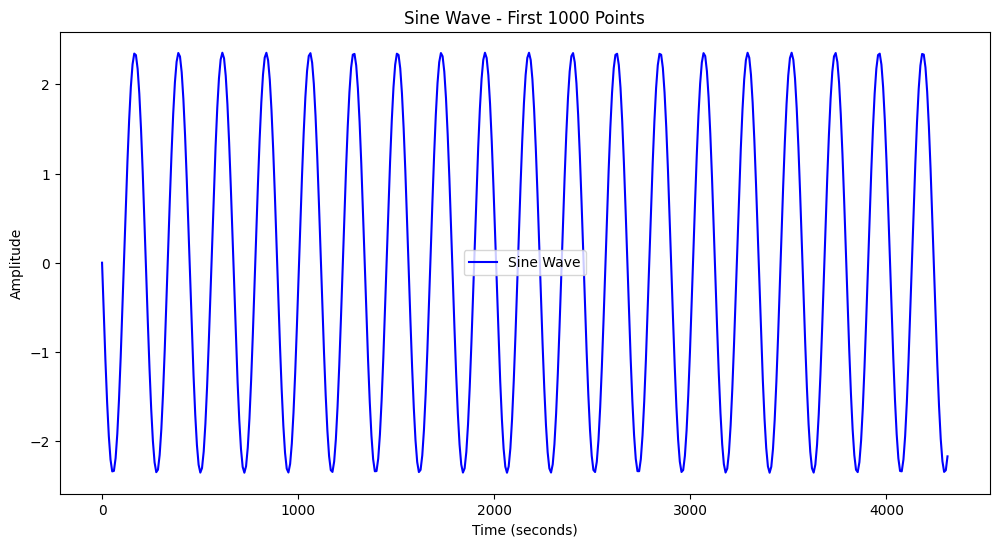

In [81]:
## Showing original plot of sine wave
print(sine_df_raw.head())
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(time[:500], sine_wave[:500], label='Sine Wave', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Sine Wave - First 1000 Points')
plt.legend()
plt.show()

In [82]:
def recursive_forecast_amplitude(model, x_init, steps=30, amplitude_idx=0):
    """
    Predict multiple future steps recursively using model's forecast head.

    Args:
        model: trained TransformerVAE model
        x_init: [1, seq_len, feature_dim] - starting input sequence for context
        steps: int - number of future steps to predict
        amplitude_idx: int - index of amplitude feature in input features

    Returns:
        preds: [1, steps] - predicted amplitude values for future steps
    """
    
    model.eval()
    preds = []
    x_curr = x_init.clone()  # [1, seq_len, feature_dim]

    with torch.no_grad():
        for _ in range(steps):
            recon, future_pred, _, _ = model(x_curr, pred_steps=1, teacher_force_prob=0.0)
            
            # Get predicted next step for amplitude
            next_feat = future_pred[:, -1, :]  # [batch_size, feature_dim]
            next_amp = next_feat[:, amplitude_idx]  # [batch_size]

            preds.append(next_amp.unsqueeze(1))  # [batch_size, 1]

            # Append predicted next step to input, slide window
            next_feat_full = next_feat.unsqueeze(1)  # [batch_size, 1, feature_dim]
            x_curr = torch.cat([x_curr[:, 1:, :], next_feat_full], dim=1)

    preds = torch.cat(preds, dim=1)  # [batch_size, steps]
    return preds


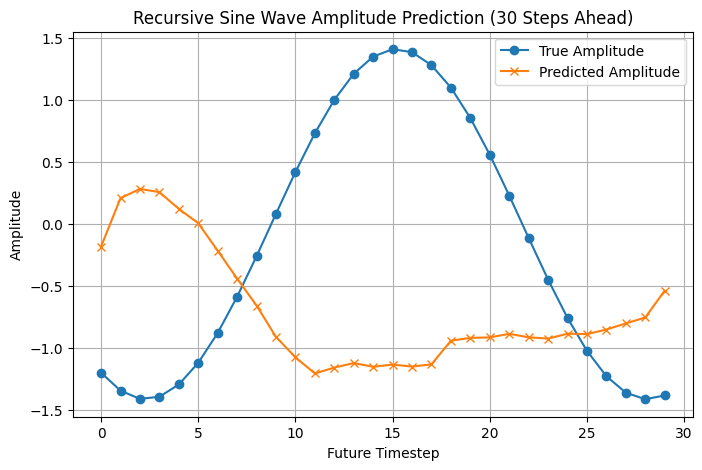

In [83]:

amplitude_idx = sine_df.columns.get_loc('Sine Amplitude')

# Example sequence for context
example_seq = sequences[0].unsqueeze(0)  # [1, seq_len, feature_dim]

# True future amplitude
true_amplitude = data_tensor[seq_len:seq_len + 30, amplitude_idx]

# Predict
predicted_amplitude = recursive_forecast_amplitude(vae, example_seq, steps=30, amplitude_idx=amplitude_idx)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(30), true_amplitude.cpu(), label='True Amplitude', marker='o')
plt.plot(range(30), predicted_amplitude.squeeze(0).cpu(), label='Predicted Amplitude', marker='x')
plt.title("Recursive Sine Wave Amplitude Prediction (30 Steps Ahead)")
plt.xlabel("Future Timestep")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()

## APPENDIX

In [84]:
# vae = TransformerVAE(feature_dim=43, d_model=64, latent_dim=16)
# optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
# loss_fn = nn.MSELoss()

# # List to store results
# results = []

# for epoch in range(5):
#     epoch_loss = 0
#     recon_loss_total = 0
#     kld_total = 0

#     for batch in loader:
#         x = batch[0]  # [batch_size, seq_len, num_features]

#         reconstructed, mu, logvar = vae(x)

#         recon_loss = loss_fn(reconstructed, x)
#         kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
#         loss = recon_loss + 0.01 * kld  # KLD weight adjustable

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()
#         recon_loss_total += recon_loss.item()
#         kld_total += kld.item()

#     avg_loss = epoch_loss / len(loader)
#     avg_recon_loss = recon_loss_total / len(loader)
#     avg_kld = kld_total / len(loader)

#     print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KLD: {avg_kld:.4f}")

#     # Append results
#     results.append({
#         "epoch": epoch + 1,
#         "total_loss": avg_loss,
#         "recon_loss": avg_recon_loss,
#         "kld_loss": avg_kld
#     })

# # Convert to DataFrame
# results_df = pd.DataFrame(results)

# # Save to CSV
# results_df.to_csv("vae_discriminator_results.csv", index=False)

# print(results_df)

In [85]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# import torch

# vae.eval()

# all_mu = []

# # Collect latent means
# with torch.no_grad():
#     for batch in loader:
#         x = batch[0]
#         mu, logvar = vae.encode(x)
#         all_mu.append(mu.cpu())

# all_mu = torch.cat(all_mu, dim=0).numpy()

# # Dimensionality reduction if needed
# if all_mu.shape[1] > 2:
#     pca = PCA(n_components=2)
#     latent_2d = pca.fit_transform(all_mu)
# else:
#     latent_2d = all_mu

# # Scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.6)
# plt.title("Latent Space Representation")
# plt.xlabel("Latent Dimension 1")
# plt.ylabel("Latent Dimension 2")
# plt.grid()
# plt.show()


In [86]:
# vae = TransformerVAE(feature_dim=43, d_model=64, latent_dim=16)
# optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
# loss_fn = nn.MSELoss()

# vae.train()

# for epoch in range(5):
#     epoch_loss = 0
#     for batch in loader:
#         x = batch[0]  # [batch_size, seq_len, num_features]

#         reconstructed, mu, logvar = vae(x)

#         recon_loss = loss_fn(reconstructed, x)
#         kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
#         loss = recon_loss + 0.01 * kld  # KLD weight adjustable

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     print(f"Epoch {epoch+1}, Avg Loss: {epoch_loss / len(loader):.4f}")


## Appendix

In [87]:
# ## 1 --> MultiHeadAttention

# class MultiHeadAttention(nn.Module):
#     def __init__(self, d_model, num_heads):
#         super(MultiHeadAttention, self).__init__()
#         # Ensure that the model dimension (d_model) is divisible by the number of heads
#         assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
#         # Initialize dimensions
#         self.d_model = d_model # Model's dimension
#         self.num_heads = num_heads # Number of attention heads
#         self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
#         # Linear layers for transforming inputs
#         self.W_q = nn.Linear(d_model, d_model) # Query transformation
#         self.W_k = nn.Linear(d_model, d_model) # Key transformation
#         self.W_v = nn.Linear(d_model, d_model) # Value transformation
#         self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
#     def scaled_dot_product_attention(self, Q, K, V, mask=None):
#         # Calculate attention scores
#         attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
#         # Apply mask if provided (useful for preventing attention to certain parts like padding)
#         if mask is not None:
#             attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
#         # Softmax is applied to obtain attention probabilities
#         attn_probs = torch.softmax(attn_scores, dim=-1)
        
#         # Multiply by values to obtain the final output
#         output = torch.matmul(attn_probs, V)
#         return output
        
#     def split_heads(self, x):
#         # Reshape the input to have num_heads for multi-head attention
#         batch_size, seq_length, d_model = x.size()
#         return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
#     def combine_heads(self, x):
#         # Combine the multiple heads back to original shape
#         batch_size, _, seq_length, d_k = x.size()
#         return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
#     def forward(self, Q, K, V, mask=None):
#         # Apply linear transformations and split heads
#         Q = self.split_heads(self.W_q(Q))
#         K = self.split_heads(self.W_k(K))
#         V = self.split_heads(self.W_v(V))
        
#         # Perform scaled dot-product attention
#         attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
#         # Combine heads and apply output transformation
#         output = self.W_o(self.combine_heads(attn_output))
#         return output


# ## 2 --> FeedForwardNetwork

# class PositionWiseFeedForward(nn.Module):
#     def __init__(self, d_model, d_ff):
#         super(PositionWiseFeedForward, self).__init__()
#         self.fc1 = nn.Linear(d_model, d_ff)
#         self.fc2 = nn.Linear(d_ff, d_model)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         return self.fc2(self.relu(self.fc1(x)))


# ## 3 --> PositionalEncoding

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_seq_length):
#         super(PositionalEncoding, self).__init__()
        
#         pe = torch.zeros(max_seq_length, d_model)
#         position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
        
#         self.register_buffer('pe', pe.unsqueeze(0))
        
#     def forward(self, x):
#         return x + self.pe[:, :x.size(1)]



In [88]:
# ## ENCODER LAYER

# class EncoderLayer(nn.Module):
#     def __init__(self, d_model, num_heads, d_ff, dropout):
#         super(EncoderLayer, self).__init__()
#         self.self_attn = MultiHeadAttention(d_model, num_heads)
#         self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, x, mask):
#         attn_output = self.self_attn(x, x, x, mask)
#         x = self.norm1(x + self.dropout(attn_output))
#         ff_output = self.feed_forward(x)
#         x = self.norm2(x + self.dropout(ff_output))
#         return x
  

In [89]:
  
# ## DECODER LAYER

# class DecoderLayer(nn.Module):
#     def __init__(self, d_model, num_heads, d_ff, dropout):
#         super(DecoderLayer, self).__init__()
#         self.self_attn = MultiHeadAttention(d_model, num_heads)
#         self.cross_attn = MultiHeadAttention(d_model, num_heads)
#         self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.norm3 = nn.LayerNorm(d_model)
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, x, enc_output, src_mask, tgt_mask):
#         attn_output = self.self_attn(x, x, x, tgt_mask)
#         x = self.norm1(x + self.dropout(attn_output))
#         attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
#         x = self.norm2(x + self.dropout(attn_output))
#         ff_output = self.feed_forward(x)
#         x = self.norm3(x + self.dropout(ff_output))
#         return x

In [90]:
# ## Transformer with Encoder

# class Transformer(nn.Module):
#     def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
#         super(Transformer, self).__init__()
#         self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
#         # self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
#         self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

#         self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
#         # self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

#         self.fc = nn.Linear(d_model, tgt_vocab_size)
#         self.dropout = nn.Dropout(dropout)

#     def generate_mask(self, src, tgt):
#         src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
#         tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
#         seq_length = tgt.size(1)
#         nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
#         tgt_mask = tgt_mask & nopeak_mask
#         return src_mask, tgt_mask

#     def forward(self, src, tgt):
#         src_mask, tgt_mask = self.generate_mask(src, tgt)
#         src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
#         tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

#         enc_output = src_embedded
#         for enc_layer in self.encoder_layers:
#             enc_output = enc_layer(enc_output, src_mask)

#         dec_output = tgt_embedded
#         for dec_layer in self.decoder_layers:
#             dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

#         output = self.fc(dec_output)
#         return enc_output
    

In [91]:
# ## Training the Transformer

# src_vocab_size = 5000
# tgt_vocab_size = 5000
# d_model = 512
# num_heads = 8
# num_layers = 6
# d_ff = 2048
# max_seq_length = 100
# dropout = 0.1

# transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)


# # # Generate random sample data
# # src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
# # tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

# criterion = nn.CrossEntropyLoss(ignore_index=0)
# optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# transformer.train()

# for epoch in range(5):
#     optimizer.zero_grad()
#     output = transformer(src_data, tgt_data[:, :-1])
#     loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
#     loss.backward()
#     optimizer.step()
#     print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

In [92]:
# transformer.eval()

# # Generate random sample validation data
# val_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
# val_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

# with torch.no_grad():

#     val_output = transformer(val_src_data, val_tgt_data[:, :-1])
#     val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
#     print(f"Validation Loss: {val_loss.item()}")

## CLASSIC AUTOENCODER WITHOUT THE CONCEPT OF TIME

## I need to add to the decoder a transformer block


class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(43, 32),   # Start with 43 features
            nn.ReLU(),
            nn.Linear(32, 24),
            nn.ReLU(),
            nn.Linear(24, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)      # Latent space with 2 features
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 24),
            nn.ReLU(),
            nn.Linear(24, 32),
            nn.ReLU(),
            nn.Linear(32, 43),    # Reconstruct 43 features
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

 Model training
import matplotlib.pyplot as plt
epochs = 5
outputs = []
losses = []


model = AE()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for health in loader:
        health = health[0]
        health = health.view(-1, 43).to(device)
        
        reconstructed = model(health)
        loss = loss_function(reconstructed, health)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, health, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

